In [2]:
#!pip3 install --user astropy

In [6]:
import numpy as np
import astropy as ap
import pandas as pd
from astropy.io import fits
import scipy.linalg as slg
from scipy.stats import norm
from math import ceil

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import glob
import os
# These are in Functions
from os.path import join as pj
# from os.path import abspath as absp

from IPython.display import Image
from IPython.display import display

from joblib import Parallel, delayed

import PIL
import pickle

import sys

In [7]:
os.environ["SPARCFIRE_HOME"] = "/home/portmanm/sparcfire_matt/"

_HOME_DIR = os.path.expanduser("~")
try:
    _SPARCFIRE_DIR = os.environ["SPARCFIRE_HOME"]
    _MODULE_DIR = pj(_SPARCFIRE_DIR, "GalfitModule")
except KeyError:
    if __name__ == "__main__":
        print("SPARCFIRE_HOME is not set. Please run 'setup.bash' inside SpArcFiRe directory if not done so already.")
        print("Checking the current directory for GalfitModule, otherwise quitting.")
            
        _MODULE_DIR = pj(os.getcwd(), "GalfitModule")
        
        if not exists(_MODULE_DIR):
            raise Exception("Could not find GalfitModule!")
    
sys.path.append(_MODULE_DIR)
from Classes.Components import *
from Classes.Containers import *
from Classes.FitsHandlers import *
from Functions.helper_functions import *

In [9]:
#run_path2 = "/home/portmanm/run2_1000_galfit"
#run_path7 = "/home/portmanm/run7_1000_galfit_three_fit"
#run_path3 = "/home/portmanm/run3_1000_galfit_psf"
run_path = os.getcwd()
if in_notebook():
    run_path = run_path.replace("ics-home", "portmanm")
    
#in_dir = pj(_HOME_DIR, "29k_galaxies_obs")
#run_dir = pj(_HOME_DIR, "29k_galaxies")
in_dir  = "sparcfire-in"
out_dir = "sparcfire-out"
tmp_dir = "sparcfire-tmp"
#galfits_tmp = "galfits"
#galfit_masks = "galfit_masks"
#galfit_out = "all_galfit_out"
nmr = "norm_masked_residual"

In [10]:
def check_galfit_chi(gal_name, base_path):
    # An example line
    # # Chi^2/nu = 4.661,  Chi^2 = 12025.575,  Ndof = 2580
    
    #galfit_txt_out = "galfit.01" # in the future galfit.01 may change
    filename = os.path.join(base_path, gal_name, galfit_txt_out)
    with open(filename, "r") as f:
        for line in f:
            if "Chi" in line:
                chi_line = line.strip("# ")
    
    # This also works but it's quite devious...
    # chi_line.replace("^", "").replace("/", "_").replace(",  ", "\n").lower()
    # exec(chi_line)
    
    out_vals = chi_line.split(",")
    chi2_nu = float(out_vals[0].strip().split("=")[-1])
    chi2 = float(out_vals[1].strip().split("=")[-1])
    ndof = int(out_vals[2].strip().split("=")[-1])
    
    return chi2_nu, chi2, ndof

In [39]:
def fill_objects(gname, count, galfit_tmp_path, galfit_mask_path, out_png_dir):
    
    #galfit_mask_path = "/home/portmanm/29k_galaxies/sparcfire-tmp/galfit_masks"
    # if gname in output_fits_dict and gname in mask_dict:
    #     continue

    if not count % 1000:
        print(count, gname)

    star_mask_name = f"{gname}_star-rm.fits"
    mask_fits_name = pj(galfit_mask_path, star_mask_name)

    try:
        fits_filename = f"{gname}_galfit_out.fits"
        fits_file = OutputFits(pj(galfit_tmp_path, fits_filename))
    except Exception as e:
        print(f"There was an issue opening galaxy {gname}. Continuing...")
        print(e)
        return None, None
    
    try:
        mask_fits_file = FitsFile(mask_fits_name)
    except Exception as e:
        print(f"There was an issue opening star mask for galaxy {gname}. Proceeding without mask...")
        # The mask gets cropped down to the crop box size anyway
        mask_fits_file = np.zeros((500,500))
    
    masked_residual_normalized = fits_file.generate_masked_residual(mask_fits_file)
    if masked_residual_normalized is None:
        #print(f"Could not calculate nmr") # for galaxy {gname}. Continuing...")
        return None, None
    
    fits_file.to_png(out_png_dir = out_png_dir) #"/home/portmanm/29k_galaxies/sparcfire-out/galfit_png")
    
    return gname, fits_file.nmr#, fits_file.nmrr

    # output_fits_dict[gname] = fits_file
    # mask_dict[gname] = mask_fits_file
    
# outpath = pj(run_dir, out_dir)
# total_gal = len(glob.glob(pj(outpath, "/123*/")))

# galfit_tmp_path = pj(run_dir, tmp_dir, galfits_tmp) 
# galfit_mask_path  = pj(run_dir, tmp_dir, galfit_masks)
# all_out = [(os.path.basename(i).rstrip("_galfit_out.fits") , i) for i in glob.glob(pj(galfit_tmp_path, "*_galfit_out.fits")) if i not in output_fits_dict]
# pickle.dump(output_fits_dict, open('output_nmr.pkl', 'wb'))

In [ ]:
basename = "some-name"
pickle_filename = f'{basename}_output_nmr.pkl'
# TODO: Faster to send this to bash and count
temp = sp(f"find {pj(out_dir, '123*')} -maxdepth 0 -type d | wc -l")
total_gal = int(temp.stdout) #len(glob.glob(pj(out_dir, "123*/")))

In [13]:
output_fits_norm_residuals = pickle.load(open(pickle_filename, 'rb'))

In [ ]:
# To include different methods of calculating the residual should they exist
output_fits_nmr  = {row[0]:row[1] for row in output_fits_norm_residuals if row[0]}
#output_fits_nmrr = {row[0]:row[2] for row in output_fits_norm_residuals if row[0]

In [14]:
norms_df = pd.DataFrame.from_dict(output_fits_nmr, orient = 'index', columns = [nmr])

In [15]:
norms_df = norms_df.query(f"{nmr} < 1")

In [16]:
norms_df = norms_df.sort_values(by=[nmr]) #, inplace=True)

In [17]:
# Allow this if some values are reallllllly bad and make seeing the graph difficult
# 0.01 is a decent starting point for this but adjust as necessary
nmr_lim = norms_df[norms_df.norm_masked_residual < 0.01]

In [18]:
run_name = "Run Something or Other"

In [19]:
graphing_df = pd.DataFrame()
# graphing_df[run2_name] = nmr2_lim[nmr]
# graphing_df[run6_name] = nmr6_lim[nmr]
graphing_df[run_name] = nmr_lim[nmr]

In [20]:
# Can graph two together, see above cell for example
#graphing_df = graphing_df.melt(id_vars = [], value_vars = [run2_name, run6_name], var_name = "Run ", value_name = nmr, ignore_index = False)
graphing_df = graphing_df.melt(id_vars = [], value_vars = [run_name], var_name = "Run ", value_name = nmr, ignore_index = False)

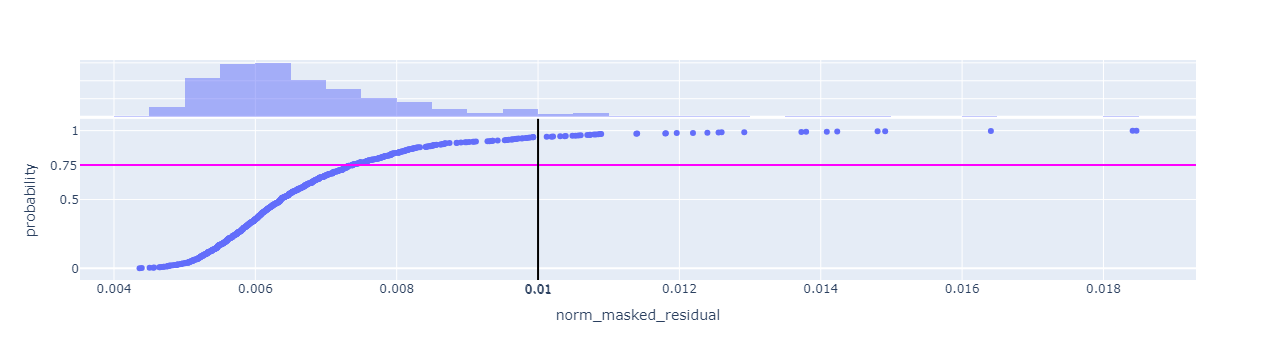

In [26]:
fig = px.ecdf(graphing_df, 
              x = nmr, 
              markers = True, 
              lines = False, 
              #facet_col = "Run ", 
              marginal = "histogram") #, facet_col_wrap = 1) # 

# yval = 0.75
# fig.add_hline(y = yval, 
#               row = 1,
#               col = 1,
#               line_color = "magenta",
#               annotation_text=f"{yval}", #from Run7", 
#               annotation_position="left")

# fig.add_hline(y = 0.69,
#               row = 1,
#               col = 2,
#               line_color = "cyan",
#               annotation_text="0.78", # from Run6", 
#               annotation_position="right")

# determine this post-facto
cutoff_val = 0.01
fig.add_vline(x = cutoff_val, 
              row = 1,
              line_color = "black",
              annotation_text= f"{cutoff_val}", 
              annotation_position="bottom")

# fig.add_trace(go.Scatter(x = np.ones(len(nmr2_lim))*0.004, y = np.linspace(0,1,num = len(nmr2_lim)), mode = "lines"))
# fig.add_trace(go.Scatter(x = np.linspace(0.002, 0.01, num = len(nmr2_lim)), y = np.ones(len(nmr2_lim))*0.75, mode = "lines"))

# fig.add_trace(go.Scatter(x = np.ones(len(nmr2_lim))*0.004, y = np.linspace(0,1,num = len(nmr2_lim))))
# fig.add_trace(go.Scatter(x = np.linspace(0.002, 0.01, num = len(nmr2_lim)), y = np.ones(len(nmr2_lim))*0.75))


fig.show()

In [ ]:
run_name = run_name.strip()

print(f"Total number of galaxies attempted: {total_gal}")
print()
print(f"Number of Galfit models generated...")
print(f"{run_name}: {len(norms_df)}/{total_gal}, {100*len(norms_df)/total_gal:.2f}%")

cutoff = norms_df.query(f"{nmr} < {cutoff_val}")
print()
print(f"Residuals below {cutoff_val} cutoff")
print(f"{run_name}: {len(cutoff)}/{len(norms_df)}, {100*len(cutoff)/len(norms_df):.2f}%")

print()
print(f"Residuals below {cutoff_val} cutoff (excluding obscene failures)...")
print(f"{run_name}: {len(cutoff)}/{len(graphing_df)}, {100*len(cutoff)/len(graphing_df):.2f}%")

In [28]:
def generate_images(input_df, png_dir:str, cutoff_val = 0.01, custom_range = None):
    images_below_cutoff = []
    images_above_cutoff = []
    
    if not custom_range:
        custom_range = range(0, len(input_df), 500) 
    
    for index_num in custom_range:
        g_nmr = input_df.iloc[index_num]
        gname = g_nmr.name
        nmr = g_nmr.norm_masked_residual

        # iloc returns a series, name returns the name of the row

        
        # print(f"chi^2/nu = {galaxy_info['chi^2_nu']:.2f}")
        # print(f"chi^2 = {galaxy_info['chi^2']:.2f}")
        print(f"{gname}, sorted #: {index_num}")
        print(f"Norm masked residual = {nmr:.6f}")
        #print(f"Dim: {galaxy_info['image_size']}x{galaxy_info['image_size']}")
        print()
        #print(f"Norm GALFIT residual = {norm_galfit_residual:.4f}")


        # galfit_cmap = grayscale_cmap('RdBu')
        # residual_plot = plt.imshow(np.flipud(masked_residual[:,:])) #, norm=colors.LogNorm())
        # residual_plot.set_cmap('Greys')
        # residual_plot.set_cmap(galfit_cmap)
        # cbar = plt.colorbar()

        #plt.imshow(residual_plot)
        #imgplot = plt.imshow(arr[:, :, 0])
        height = 500
        width = 500
        size = (height, width)
        #out_str = galaxy_info.name.replace("galfit_out.fits", "combined.png").strip()
        out_str = f"{gname}_combined.png"
        #print(out_str)
        if nmr < cutoff_val:
            images_below_cutoff.append(Image(filename = pj(png_dir, out_str), width=width, height=height))
            #images_below_cutoff.append(PIL.Image.open(pj(png_dir, out_str)).resize(size))
        else:
            images_above_cutoff.append(Image(filename = pj(png_dir, out_str), width=width, height=height))
            #images_above_cutoff.append(PIL.Image.open(pj(png_dir, out_str)).resize(size))
            
    return images_below_cutoff, images_above_cutoff

In [29]:
# https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o
# Could also be useful https://eltos.github.io/gradient/#FFFFFF-A5A5A5-000000-A5A5A5-FFFFFF
png_dir = os.path.join(run_path, out_dir, "galfit_png")
below, above = generate_images(norms_df, png_dir, cutoff_val = cutoff_val)#, custom_range = range(0, 30))

1237671262278582530, sorted #: 0
Norm masked residual = 0.004362



In [2]:
# For looking at individual galaxies
# gname = "1237665566076240061"
# gname_fits = OutputFits(pj(out_dir, gname, gname + "_galfit_out.fits"))
# print(gname_fits.feedme.arms)

In [ ]:
display(*below)

In [ ]:
display(*above)

In [ ]:
size_sorted2 = norms2_df.sort_values(by=['image_size'])[::-1]
size_sorted6 = norms6_df.sort_values(by=['image_size'])[::-1]

In [ ]:
png_dir2 = os.path.join(run_path2, sparc_out, galfit_out, "galfit_png/")
top_10_by_size2, _ = generate_images(size_sorted2, png_dir2, cutoff = 0.004, custom_range = range(10))
print("=============================================\n")
top_10_by_size6, _ = generate_images(size_sorted6, png_dir6, cutoff = 0.004, custom_range = range(10))

In [ ]:
display(*top_10_by_size6)

In [ ]:
# Grab top 1000 highest resolution galaxies from Darren's 27K and run this on those
# Change pitch angle plotting to only plot sparcfire's line between r_in and r_out and see how that compare to galfit
# Tile residuals for presentation???

In [ ]:
# Thanks to https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html
def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)